---
title: "Preparing a retention time data set for machine learning"
date: last-modified
author:
- name: Robbin Bouwmeester
  orcid: 0000-0001-6807-7029
  affiliations:
    - VIB-UGent Center for Medical Biotechnology, VIB, Belgium
    - Department of Biomolecular Medicine, Ghent University, Belgium
---

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ProteomicsML/ProteomicsML/blob/main/tutorials/retentiontime/_mq-evidence-to-ml.ipynb)

# Preparing a retention time data set for machine learning

In [ ]:
# Skip if pygam already installed
! pip install pygam
! pip install tqdm

In [ ]:
from collections import Counter
import os

from pygam import LinearGAM, s, f
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In this tutorial you will learn how to go from MaxQuant evidence files to a data set that is ready for training a retention time prediction model. Retention time is the time it takes for an analyte travels through a column. The travel time depends on the interaction with the stationary phase (usually C18 for proteomics) and mobile phase. Where the mobile phase consists of solvents and changes in physicochemical properties over time with a predefined gradient. The stationary phase remains the same over time. This allows for peptides to elude at different time points, e.g., when it prefers to interact with the mobile phase at a certain percentage of the hydrophobic solvent.

The retention time between different runs can differ significantly and depending on the abundance of the precusor calling the elution apex can be difficult. This means we need to preprocess the data before it is used for machine learning. 

## Reading and formatting input data

We will not need all the columns, define those that might be useful:

In [ ]:
sel_columns = [
    'Raw file', 'Sequence', 'Length', 'Modifications', 'Modified sequence',
    'Retention time','Retention length','Calibrated retention time',
    'Calibrated retention time start', 'Calibrated retention time finish',
    'Retention time calibration', 'Match time difference',"Intensity", "PEP"
]

Read the input files, here a csv. If you read the standard txt you need to modify the read_csv with:

```pd.read_csv("evid_files/PXD028248_evidence_selected_columns.csv",sep="\t",low_memory=False)```

Fill all the NA values with 0.0 and filter on only the most confident identificaitons (PEP <= 0.001).

In [ ]:
evid_df = pd.read_csv("https://github.com/ProteomicsML/ProteomicsML/blob/main/datasets/retentiontime/PXD028248/PXD028248_evidence_selected_columns.zip?raw=true",compression="zip",low_memory=False)
evid_df.fillna(0.0,inplace=True)
evid_df = evid_df[evid_df["PEP"] <= 0.001][sel_columns]

The file in a pandas dataframe looks like this:

In [ ]:
evid_df

,Raw file,Sequence,Length,Modifications,Modified sequence,Retention time,Retention length,Calibrated retention time,Calibrated retention time start,Calibrated retention time finish,Retention time calibration,Match time difference,Intensity,PEP
0,20191028_SJ_QEx_LC1200_4_Sommerfeld_OC218_ADP_...,AAAAAAAAAAGAAGGR,16,Acetyl (Protein N-term),_(Acetyl (Protein N-term))AAAAAAAAAAGAAGGR_,90.531,0.58251,90.531,90.202,90.784,0.000000e+00,0.0,40715000.0,9.822100e-15
1,20191126_SJ_QEx_LC1200_4_Sommerfeld_OC218_Tumo...,AAAAAAAAAAGAAGGR,16,Acetyl (Protein N-term),_(Acetyl (Protein N-term))AAAAAAAAAAGAAGGR_,97.132,0.51271,97.132,96.824,97.337,0.000000e+00,0.0,19359000.0,4.269700e-21
2,20191129_SJ_QEx_LC1200_4_Sommerfeld_OC193_Tumo...,AAAAAAAAAAGAAGGR,16,Acetyl (Protein N-term),_(Acetyl (Protein N-term))AAAAAAAAAAGAAGGR_,97.495,0.82283,97.495,96.848,97.671,0.000000e+00,0.0,173850000.0,1.198900e-42
3,20191129_SJ_QEx_LC1200_4_Sommerfeld_OC193_Tumo...,AAAAAAAAAAGAAGGR,16,Acetyl (Protein N-term),_(Acetyl (Protein N-term))AAAAAAAAAAGAAGGR_,96.580,0.46060,96.580,96.321,96.781,0.000000e+00,0.0,10126000.0,3.280800e-05
4,20191204_SJ_QEx_LC1200_4_Sommerfeld_OC217_Tumo...,AAAAAAAAAAGAAGGR,16,Acetyl (Protein N-term),_(Acetyl (Protein N-term))AAAAAAAAAAGAAGGR_,91.611,0.58345,91.611,91.341,91.924,0.000000e+00,0.0,16703000.0,4.950100e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056802,20191204_SJ_QEx_LC1200_4_Sommerfeld_OC189_Tumo...,YYYVCQYCPAGNWANR,16,Unmodified,_YYYVCQYCPAGNWANR_,93.503,0.45542,93.503,93.299,93.754,0.000000e+00,0.0,4054800.0,8.095500e-04
1056803,20191204_SJ_QEx_LC1200_4_Sommerfeld_OC196_Tumo...,YYYVCQYCPAGNWANR,16,Unmodified,_YYYVCQYCPAGNWANR_,93.772,0.57550,93.772,93.492,94.067,0.000000e+00,0.0,13780000.0,2.618200e-04
1056804,20191204_SJ_QEx_LC1200_4_Sommerfeld_OC217_Tumo...,YYYVCQYCPAGNWANR,16,Unmodified,_YYYVCQYCPAGNWANR_,93.183,0.60296,93.183,92.890,93.493,-1.421100e-14,0.0,9741300.0,1.367500e-06
1056805,20191210_SJ_QEx_LC1200_4_Sommerfeld_OC221_Tumo...,YYYVCQYCPAGNWANR,16,Unmodified,_YYYVCQYCPAGNWANR_,95.546,0.50088,95.546,95.292,95.793,-1.421100e-14,0.0,7791200.0,1.803700e-11


As you can see in this example there are many of the same peptidoforms (minus charge) for the different runs. We will want to create a single value for each peptidoform per run in a matrix instead of a single peptidoform+run combo per row.

In [ ]:
retention_dict = {}

# Group by the raw file
for gidx,g in evid_df.groupby("Raw file"):
    # Group by peptidoform and take the mean for each group
    retention_dict[gidx]  = g.groupby("Modified sequence").mean()["Calibrated retention time"].to_dict()
    
#Transform the dictionary in a df where each row is a peptidoform and each column a run
retention_df = pd.DataFrame(retention_dict)

retention_df

,20191028_SJ_QEx_LC1200_4_Sommerfeld_0Wert_ADP_73,20191028_SJ_QEx_LC1200_4_Sommerfeld_0Wert_ADP_74,20191028_SJ_QEx_LC1200_4_Sommerfeld_0Wert_ADP_75,20191028_SJ_QEx_LC1200_4_Sommerfeld_0Wert_ADP_76,20191028_SJ_QEx_LC1200_4_Sommerfeld_0Wert_ADP_77,20191028_SJ_QEx_LC1200_4_Sommerfeld_0Wert_ADP_78,20191028_SJ_QEx_LC1200_4_Sommerfeld_0Wert_ADP_79,20191028_SJ_QEx_LC1200_4_Sommerfeld_0Wert_ADP_80,20191028_SJ_QEx_LC1200_4_Sommerfeld_0Wert_ADP_81,20191028_SJ_QEx_LC1200_4_Sommerfeld_0Wert_HPMC_FCS_82,...,20200319_SJ_QEx_LC1200_4_Sommerfeld_OC221_HPMC_50Asc_522,20200319_SJ_QEx_LC1200_4_Sommerfeld_OC222_HPMC_50Asc_523,20200319_SJ_QEx_LC1200_4_Sommerfeld_OC222_HPMC_50Asc_524,20200319_SJ_QEx_LC1200_4_Sommerfeld_OC222_HPMC_50Asc_525,20200319_SJ_QEx_LC1200_4_Sommerfeld_OC222_HPMC_50Asc_526,20200319_SJ_QEx_LC1200_4_Sommerfeld_OC222_HPMC_50Asc_527,20200319_SJ_QEx_LC1200_4_Sommerfeld_OC222_HPMC_50Asc_528,20200319_SJ_QEx_LC1200_4_Sommerfeld_OC222_HPMC_50Asc_529,20200319_SJ_QEx_LC1200_4_Sommerfeld_OC222_HPMC_50Asc_530,20200319_SJ_QEx_LC1200_4_Sommerfeld_OC222_HPMC_50Asc_531
_(Acetyl (Protein N-term))ACGLVASNLNLKPGECLR_,106.540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,73.638,NaN,NaN,NaN,72.596,NaN,NaN,NaN
_(Acetyl (Protein N-term))AEEGIAAGGVM(Oxidation (M))DVNTALQEVLK_,138.075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,121.063333,121.605,NaN,NaN,NaN,NaN,NaN,NaN,NaN
_(Acetyl (Protein N-term))AGWNAYIDNLM(Oxidation (M))ADGTCQDAAIVGYK_,136.850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,107.397250,107.130,NaN,NaN,NaN,NaN,NaN,NaN,NaN
_(Acetyl (Protein N-term))SDAAVDTSSEITTK_,62.757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,34.013000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
_AADDTWEPFASGK_,90.319,89.749,NaN,88.939,NaN,NaN,NaN,NaN,NaN,105.24,...,NaN,55.282000,54.873,52.801,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
_TALLTWTEPPVR_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.442
_TQFNNNEYSQDLDAYNTKDK_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.327
_VATGTDLLSGTR_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.155
_VNWMPPPSR_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.657


We can than have a look at the absence of each peptidoform in all runs (value = absence in that many runs):

In [ ]:
prevelence_peptides = retention_df.isna().sum(axis=1)
print(prevelence_peptides)

_(Acetyl (Protein N-term))ACGLVASNLNLKPGECLR_                          385
_(Acetyl (Protein N-term))AEEGIAAGGVM(Oxidation (M))DVNTALQEVLK_       408
_(Acetyl (Protein N-term))AGWNAYIDNLM(Oxidation (M))ADGTCQDAAIVGYK_    397
_(Acetyl (Protein N-term))SDAAVDTSSEITTK_                              430
_AADDTWEPFASGK_                                                        359
                                                                      ... 
_TALLTWTEPPVR_                                                         440
_TQFNNNEYSQDLDAYNTKDK_                                                 440
_VATGTDLLSGTR_                                                         440
_VNWMPPPSR_                                                            440
_VTDIDSDDHQVM(Oxidation (M))YIM(Oxidation (M))K_                       440
Length: 49983, dtype: int64


We can penalize the absence the absence of highly abundant peptidoforms per run (lower = more abundant peptidoforms present) by taking the dot product of presence/absence in the matrix and the above absence scores:

In [ ]:
score_per_run = retention_df.isna().astype(int).T.dot(prevelence_peptides)
score_per_run.sort_values(ascending=True)

20200319_SJ_QEx_LC1200_4_Sommerfeld_OC186_HPMC_50Asc_498     18417985
20200319_SJ_QEx_LC1200_4_Sommerfeld_OC186_HPMC_50Asc_499     18633580
20200319_SJ_QEx_LC1200_4_Sommerfeld_OC186_HPMC_50Asc_502     18802678
20200319_SJ_QEx_LC1200_4_Sommerfeld_OC186_HPMC_50Asc_501     18807279
20191129_SJ_QEx_LC1200_4_Sommerfeld_OC193_Tumor_50Asc_138    18877939
                                                               ...   
20191028_SJ_QEx_LC1200_4_Sommerfeld_0Wert_HPMC_FCS_85        21261614
20191121_SJ_QEx_LC1200_4_Sommerfeld_0Wert_CAF_FCS_100        21262661
20191028_SJ_QEx_LC1200_4_Sommerfeld_0Wert_HPMC_FCS_83        21263993
20191028_SJ_QEx_LC1200_4_Sommerfeld_0Wert_HPMC_FCS_82        21265683
20191028_SJ_QEx_LC1200_4_Sommerfeld_0Wert_HPMC_FCS_87        21268762
Length: 441, dtype: int64

We will use a single run to align all the first experiments against, this is the one with the lowest penalty score:

In [ ]:
run_highest_overlap_score = score_per_run.sort_values(ascending=True).index[0]

## Retention time alignment between runs

The first step after reading and loading the data is to align retention times between runs. Here we will use splines in a GAM for that. The algorithm below follows these steps:

1. Iterate over all runs, sorted by the earlier defined penalty score
2. Obtain the overlapping peptidoforms between runs
3. If there are less than 20 peptidoforms skip that run
4. Divide the overlapping peptides into equidistant bins and enforce a percentage of the bins to be filled with a least one peptidoform (now 200 bins and 75 % occupancy). If requirements are not met skip that run.
5. Fit the GAM with splines between the reference set and the selected run
6. Calculate the error between aligned and values in the reference set. If selected it will run a second stage of the GAM filtering out any data points that were selected to have an error that is too high
7. Assign aligned values to a new matrix
8. Change the reference dataset to be the median of all aligned runs and the initial reference run

In the next code block we will define two kinds of plots, first a performance scatter plot. Here we plot the retention time of the selected set against the reference set; before and after alignment. Next is the residual plot that subtracts the diagonal from the performance scatter plot and essentially shows the errors before and after alignment. The residual plot is generated for both the first and second stage GAM.

In [ ]:
def plot_performance(retention_df,run_highest_overlap_score,align_name,non_na_sel):
        plt.scatter(
                    retention_df[run_highest_overlap_score][non_na_sel],
                    retention_df[align_name][non_na_sel],
                    alpha=0.05,
                    s=10,
                    label="Reference+selected set unaligned"
                )

        plt.scatter(
                    retention_df[run_highest_overlap_score][non_na_sel],
                    gam_model_cv.predict(retention_df[align_name][non_na_sel]),
                    alpha=0.05,
                    s=10,
                    label="Reference+selected set aligned"
                )
        plt.plot(
            [
            min(retention_df[run_highest_overlap_score][non_na_sel]),
            max(retention_df[run_highest_overlap_score][non_na_sel])

            ],
            [
                min(retention_df[run_highest_overlap_score][non_na_sel]),
                max(retention_df[run_highest_overlap_score][non_na_sel])

            ],
            c="black",
            linestyle="--",
            linewidth=1.0
        )
        plt.xlabel("Retention time reference set")
        plt.ylabel("Retention time selected set")
        leg = plt.legend()
        for lh in leg.legendHandles: 
            lh.set_alpha(1)

        plt.show()
        

def plot_residual(run_highest_overlap_score,align_name,non_na_sel,title="Residual plot"):
        plt.scatter(
                    retention_df[run_highest_overlap_score][non_na_sel],
                    retention_df[align_name][non_na_sel]-retention_df[run_highest_overlap_score][non_na_sel],
                    alpha=0.05,
                    s=10
                )

        plt.scatter(
                    retention_df[run_highest_overlap_score][non_na_sel],
                    gam_model_cv.predict(retention_df[align_name][non_na_sel])-retention_df[run_highest_overlap_score][non_na_sel],
                    alpha=0.05,
                    s=10
                )
        
        plt.title(title)
        
        plt.axhline(
            y = 0.0, 
            color = "black",
            linewidth=1.0,
            linestyle = "--"
        )
        
        plt.ylabel("Residual")
        plt.xlabel("Retention time reference")

        plt.show()

Processing 20200319_SJ_QEx_LC1200_4_Sommerfeld_OC186_HPMC_50Asc_499: : 0it [00:00, ?it/s]

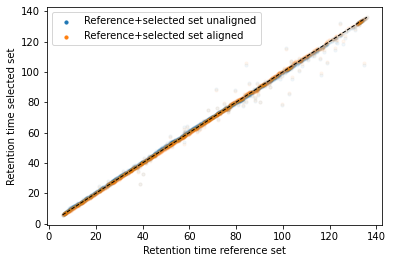

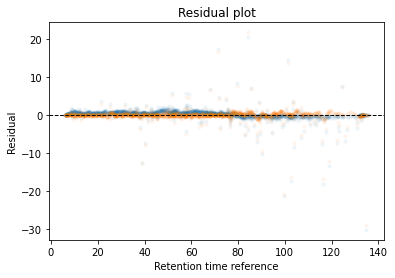

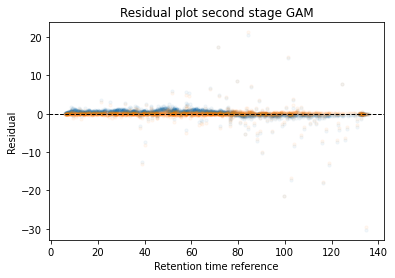

Processing 20200109_SJ_QEx_LC1200_4_Sommerfeld_OC221_Tumor_5FCS_340: : 100it [01:23,  1.29it/s]

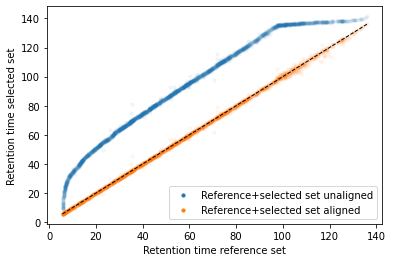

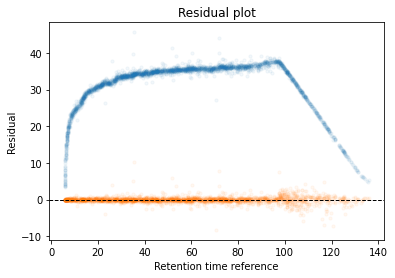

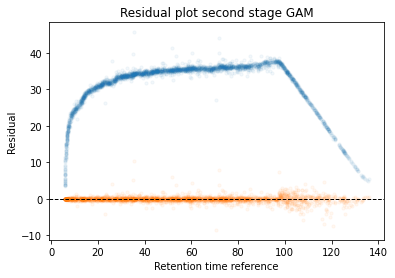

Processing 20200109_SJ_QEx_LC1200_4_Sommerfeld_OC217_Tumor_5FCS_318: : 200it [02:42,  1.42it/s] 

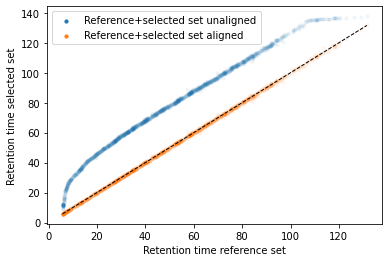

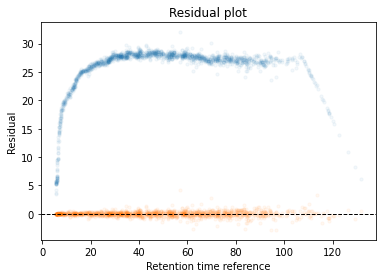

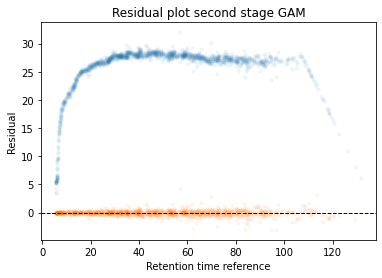

Processing 20191210_SJ_QEx_LC1200_4_Sommerfeld_OC195_Tumor_50Asc_280: : 300it [03:54,  1.37it/s]

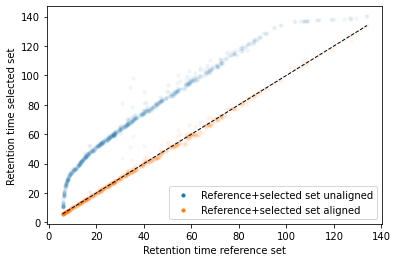

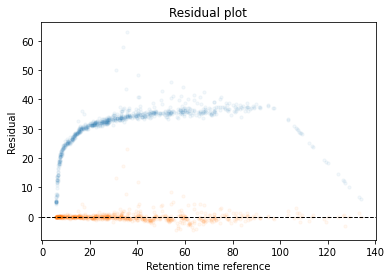

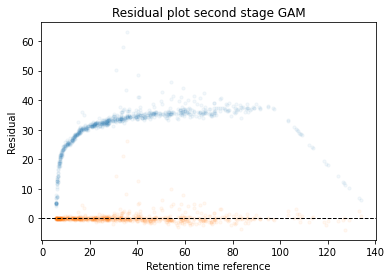

Processing 20191028_SJ_QEx_LC1200_4_Sommerfeld_0Wert_HPMC_FCS_87: : 440it [04:40,  1.57it/s]    


In [ ]:
#constraints = "monotonic_inc"
constraints = "none"

# Align parameters
perform_second_stage_robust = True
error_filter_perc = 0.005
num_splines = 150
min_coverage = 0.75
coverage_div = 200
plot_res_every_n = 100
min_overlap = 20

run_highest_overlap_score = score_per_run.sort_values(ascending=True).index[0]

unique_peptides = []
unique_peptides.extend(list(retention_df[retention_df[run_highest_overlap_score].notna()].index))

retention_df_aligned = retention_df.copy()

keep_cols = [run_highest_overlap_score]

error_filter_perc_threshold = max(retention_df[run_highest_overlap_score])*error_filter_perc

# Iterate over runs sorted by a penalty score
# For version 3.8 or later uncomment the for loop below and comment the other for loop; also uncomment the line after update progressbar
#for idx,align_name in (pbar := tqdm(enumerate(score_per_run.sort_values(ascending=True)[1:].index))):
for idx,align_name in tqdm(enumerate(score_per_run.sort_values(ascending=True)[1:].index)):
    # Update progressbar
    #pbar.set_description(f"Processing {align_name}")
    
    # Check overlap between peptidoforms
    non_na_sel = (retention_df[align_name].notna()) & (retention_df[run_highest_overlap_score].notna())
    
    # Continue if insufficient overlapping peptides
    if len(retention_df[run_highest_overlap_score][non_na_sel].index) < min_overlap:
        continue
    
    # Check spread of overlapping peptidoforms, continue if not sufficient
    if (len(set(pd.cut(retention_df[align_name][non_na_sel], coverage_div, include_lowest = True))) / coverage_div) < min_coverage:
        continue
    
    # Fit the GAM
    gam_model_cv = LinearGAM(s(0, n_splines=num_splines), constraints=constraints, verbose=True).fit(
                                                            retention_df[align_name][non_na_sel], 
                                                            retention_df[run_highest_overlap_score][non_na_sel])
    
    
    # Plot results alignment
    if idx % plot_res_every_n == 0 or idx == 0:
        plot_performance(
            retention_df,
            run_highest_overlap_score,
            align_name,
            non_na_sel
        )
        plot_residual(
            run_highest_overlap_score,
            align_name,
            non_na_sel
        )

    
    # Calculate errors and create filter that can be used in the second stage
    errors = abs(gam_model_cv.predict(retention_df[align_name][non_na_sel])-retention_df[run_highest_overlap_score][non_na_sel])
    error_filter = errors < error_filter_perc_threshold
    
    # Perform a second stage GAM removing high error from previous fit
    if perform_second_stage_robust:
        gam_model_cv = LinearGAM(s(0, n_splines=num_splines), constraints=constraints, verbose=True).fit(
                                                                retention_df[align_name][non_na_sel][error_filter], 
                                                                retention_df[run_highest_overlap_score][non_na_sel][error_filter])

        if idx % plot_res_every_n == 0  or idx == 0:
            plot_residual(
            run_highest_overlap_score,
            align_name,
            non_na_sel,
            title="Residual plot second stage GAM"
        )
            
    
    # Write alignment to new matrix
    retention_df_aligned.loc[retention_df[align_name].notna(),align_name] = gam_model_cv.predict(retention_df.loc[retention_df[align_name].notna(),align_name])

    unique_peptides.extend(list(retention_df[retention_df[align_name].notna()].index))
    
    keep_cols.append(align_name)
        
    # Create reference set based on aligned retention times
    retention_df["median_aligned"] = retention_df_aligned[keep_cols].median(axis=1)
    run_highest_overlap_score = "median_aligned"

The data points acquired looks as the following vector:

In [ ]:
retention_df_aligned[keep_cols].median(axis=1)

_(Acetyl (Protein N-term))ACGLVASNLNLKPGECLR_                           70.639004
_(Acetyl (Protein N-term))AEEGIAAGGVM(Oxidation (M))DVNTALQEVLK_       118.580954
_(Acetyl (Protein N-term))AGWNAYIDNLM(Oxidation (M))ADGTCQDAAIVGYK_    106.010118
_(Acetyl (Protein N-term))SDAAVDTSSEITTK_                               28.451475
_AADDTWEPFASGK_                                                         54.339311
                                                                          ...    
_TALLTWTEPPVR_                                                          70.065188
_TQFNNNEYSQDLDAYNTKDK_                                                  39.432309
_VATGTDLLSGTR_                                                          30.655512
_VNWMPPPSR_                                                             35.224075
_VTDIDSDDHQVM(Oxidation (M))YIM(Oxidation (M))K_                        27.263047
Length: 49983, dtype: float64

If we look at the standard deviation we can see that this is still relatively large for some peptidoforms:

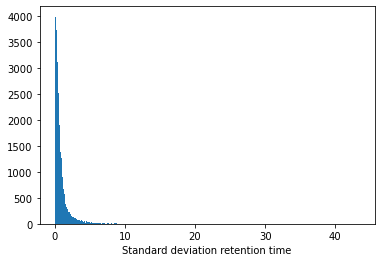

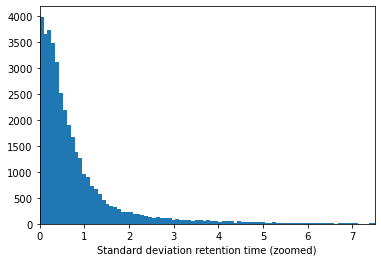

In [ ]:
plt.hist(retention_df_aligned[keep_cols].std(axis=1),bins=500)
plt.xlabel("Standard deviation retention time")
plt.show()

plt.hist(retention_df_aligned[keep_cols].std(axis=1),bins=500)
plt.xlim(0,7.5)
plt.xlabel("Standard deviation retention time (zoomed)")
plt.show()

In addition to the std there is another factor that can play a big role, the amount of times a peptidoform was observed:

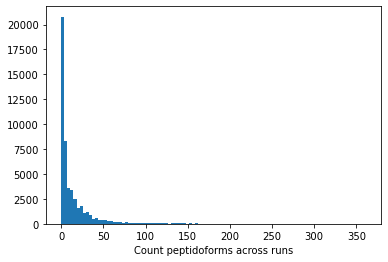

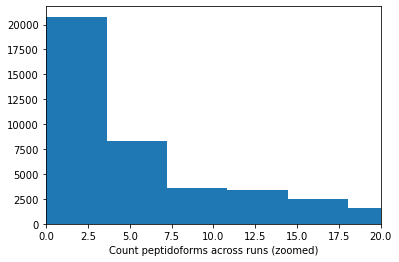

In [ ]:
plt.hist(retention_df_aligned[keep_cols].notna().sum(axis=1),bins=100)
plt.xlabel("Count peptidoforms across runs")
plt.show()

plt.hist(retention_df_aligned[keep_cols].notna().sum(axis=1),bins=100)
plt.xlabel("Count peptidoforms across runs (zoomed)")
plt.xlim(0,20)
plt.show()

If we plot both values against each other we get the following plot (the lines indicate possible thresholds):

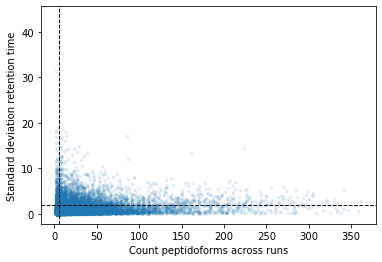

In [ ]:
plt.scatter(
    retention_df_aligned[keep_cols].notna().sum(axis=1),
    retention_df_aligned[keep_cols].std(axis=1),
    s=5,
    alpha=0.1
)

plt.ylabel("Standard deviation retention time")
plt.xlabel("Count peptidoforms across runs")

plt.axhline(
    y = 2.0, 
    color = "black",
    linewidth=1.0,
    linestyle = "--"
)

plt.axvline(
    x = 5.0, 
    color = "black",
    linewidth=1.0,
    linestyle = "--"
)

plt.show()

If we set a threshold for a minimum of 5 observations and a maximum standard deviation of 2 we get the following final data set. Here we take the median for each peptidoform across all runs:

In [ ]:
min_observations = 5
max_std = 2.0

observation_filter = retention_df_aligned[keep_cols].notna().sum(axis=1) > min_observations
std_filter = retention_df_aligned[keep_cols].std(axis=1) < max_std

retention_df_aligned[keep_cols][(observation_filter) & (std_filter)].median(axis=1)

_(Acetyl (Protein N-term))SDAAVDTSSEITTK_     28.451475
_AADDTWEPFASGK_                               54.339311
_AAGVNVEPFWPGLFAK_                           104.666562
_AAPSVTLFPPSSEELQANK_                         64.668819
_ADDKETCFAEEGKK_                               6.963496
                                                ...    
_AEPYCSVLPGFTFIQHLPLSER_                     106.951930
_AFMTADLPNELIELLEK_                          131.490540
_IAQLRPEDLAGLAALQELDVSNLSLQALPGDLSGLFPR_     132.956933
_VETNMAFSPFSIASLLTQVLLGAGENTK_               136.516511
_VNTFSALANIDLALEQGDALALFR_                   133.205437
Length: 21588, dtype: float64